In [1]:
import requests, time, itertools, math, shutil
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import numpy as np

from court import court_shapes

pd.set_option('display.max_columns',40)
import warnings
warnings.filterwarnings('ignore')

import ipywidgets as widgets
from ipywidgets import interact

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

from shot_chart_viz import find_shootingPcts, draw_court, acquire_playerPic, cdict

In [94]:
df = pd.read_csv('data/final_df.csv',index_col=0)

## SHOT CHARTS + DROPDOWNS

In [3]:
# team_dropdown = widgets.Dropdown(
#     options = sorted(list(set(df.team_name))),
#     value='New York Knicks',
#     description='Team:',
#     disabled=False,
# )

# interact(draw_team_sc, team=team_dropdown);

In [352]:
player_dropdown = widgets.Dropdown(
    options = sorted(list(set(df.name))),
    value='James Harden',
    description='Player:',
    disabled=False,
)

# style = widgets.Style()

grid_slider = widgets.IntSlider(
    value=15,
    min=5, max=60,
    step=5,
    description='Bubble Size:',
    disabled=False,
)

interact(freq_shooting_plot, player_name=player_dropdown, gridNum=grid_slider);

interactive(children=(Dropdown(description='Player:', index=200, options=('AJ Price', 'Aaron Brooks', 'Aaron G…

## HEXBIN CHARTS

In [491]:
def freq_shooting_plot(player_name,gridNum=15):
    plot_size=(12,8)
    shot_df = df[df.name==player_name]
    
    from matplotlib.patches import Circle
    x = shot_df.x[shot_df['y']<425.1]
    y = shot_df.y[shot_df['y']<425.1]

    #compute shooting percentage and # of shots
    (ShootingPctLocs, shotNumber) = find_shootingPcts(shot_df, gridNum)

    #draw figure and court
    fig = plt.figure(figsize=plot_size)#(12,7)
    cmap = mymap #my modified colormap
    ax = plt.axes([0.1, 0.1, 0.8, 0.8]) #where to place the plot within the figure
    draw_court(outer_lines=False)
    plt.xlim(-250,250)
    plt.ylim(400, -25)

    #draw player image
    zoom = np.float(plot_size[0])/(12.0*2) #how much to zoom the player's pic. I have this hackily dependent on figure size
    img = acquire_playerPic(shot_df.player_id, zoom)
    ax.add_artist(img)

    #draw circles
    for i, shots in enumerate(ShootingPctLocs):
        restricted = Circle(shotNumber.get_offsets()[i], radius=shotNumber.get_array()[i],
                            color=cmap(shots),alpha=0.8, fill=True)
        if restricted.radius > 240/gridNum: restricted.radius=240/gridNum
        ax.add_patch(restricted)
    
    #draw color bar
    ax2 = fig.add_axes([0.95, 0.1, 0.02, 0.8])
    cb = matplotlib.colorbar.ColorbarBase(ax2,cmap=cmap, orientation='vertical')
    cb.set_label('Field Goal %')
    cb.set_ticks([0.0, 0.25, 0.5, 0.75, 1.0])
    cb.set_ticklabels(['0%','25%', '50%','75%', '100%'])

    ax.set_title(shot_df.name.unique()[0] +' - Shot Chart 2014-15')
    #plot season stats
    ax.text(150,395,get_season_stats(player_name)[1])
    plt.show()
    return ax

In [489]:
from matplotlib.colors import LinearSegmentedColormap
cdict = {
    'blue': [(0.0, 0.6313725709915161, 0.6313725709915161), (0.25, 0.4470588266849518, 0.4470588266849518),
             (0.5, 0.29019609093666077, 0.29019609093666077), (0.75, 0.11372549086809158, 0.11372549086809158),
             (1.0, 0.05098039284348488, 0.05098039284348488)],
    'green': [(0.0, 0.7333333492279053, 0.7333333492279053), (0.25, 0.572549045085907, 0.572549045085907),
              (0.5, 0.4156862795352936, 0.4156862795352936), (0.75, 0.0941176488995552, 0.0941176488995552),
              (1.0, 0.0, 0.0)],
    'red': [(0.0, 0.9882352948188782, 0.9882352948188782), (0.25, 0.9882352948188782, 0.9882352948188782),
            (0.5, 0.9843137264251709, 0.9843137264251709), (0.75, 0.7960784435272217, 0.7960784435272217),
            (1.0, 0.40392157435417175, 0.40392157435417175)]
}
mymap = matplotlib.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

mymap=mymap.from_list('Color Map',[(0,'#000099'),(.25,'#402699'),(.50,'#e60000'),(1,'#660000')])

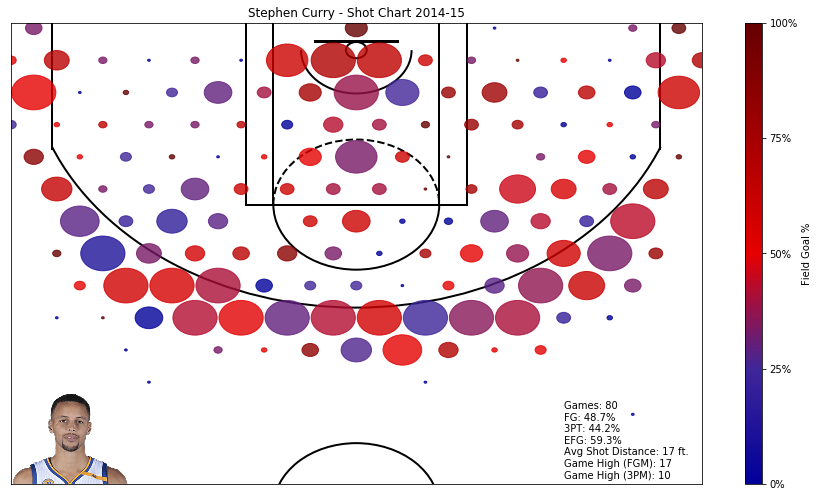

In [550]:
freq_shooting_plot("Stephen Curry")

In [486]:
def acquire_playerPic(player_id, zoom, offset=(-165,400)):
    from matplotlib import offsetbox as osb

    url = "http://stats.nba.com/media/players/230x185/"+str(player_id.unique()[0])+".png"
    pic = requests.get(url,stream=True)

    with open('img.png', 'wb') as out_file:
        shutil.copyfileobj(pic.raw, out_file)

    player_pic = plt.imread('img.png')
    img = osb.OffsetImage(player_pic, zoom)
    img = osb.AnnotationBbox(img, offset,xycoords='data',pad=0.0, box_alignment=(1,0), frameon=False)

    return img

In [549]:
def get_season_stats(player_name):
    player = df[df.name==player_name]
    
    stats = {}
    
    stats['NUM_GAMES'] = len(player.game_date.unique())
    stats['FG_PCT'] = player.groupby(by=['season']).mean().shot_made_flag.sum()
    stats['THREE_PT_PCT'] = player[player.shot_type==3].groupby(by=['season']).mean().shot_made_flag.sum()
    
    twos = player.groupby(['shot_type']).sum().iloc[0].shot_made_flag
    threes = player.groupby(['shot_type']).sum().iloc[1].shot_made_flag * 1.5
    stats['EFFECTIVE_FG_PCT'] = (twos+threes)/player.shape[0]
    
    stats['AVG_SHOT_DISTANCE'] = round(player.shot_distance.mean())
    stats['MOST_FGM'] = player.groupby('game_date').sum().shot_made_flag.max()
    stats['MOST_THREES_MADE'] = player[player.shot_type==3].groupby(by=['game_date']).sum().shot_made_flag.max()
    
    printout = """Games: {}\nFG: {:4.1%}\n3PT: {:4.1%}\nEFG: {:4.1%}\nAvg Shot Distance: {} ft.
Game High (FGM): {}\nGame High (3PM): {}""".format(*[stats.get(k) for k in stats.keys()])

    return stats, printout

sc_stats = get_season_stats('Stephen Curry')

In [225]:
pd.set_option('display.max_columns',500)
sc.head(1)

,name,pos,age,player_id,team_name,team_id,game_date,game_id,game_event_id,season,minutes_remaining,seconds_remaining,shot_made_flag,action_type,shot_type,shot_distance,x,y,dribbles,touch_time,opponent,opp_id,defender_name,defender_distance,shot_clock,lg_avg,htm,vtm,is_home,prev_shot_made,prev_2_made,prev_3_made,mid_R_pct,mid_C_pct,mid_L_pct,restricted_pct,heave_pct,ab_3_R_pct,ab_3_C_pct,ab_3_L_pct,paint_R_pct,paint_C_pct,paint_L_pct,corner_3_R_pct,corner_3_L_pct,defender_id,Above Break 3,Corner 3,Heave,Mid Range,Paint,Restricted Area,C,L,R,blk_pct,dws,dbpm
392,Stephen Curry,PG,26,201939,Golden State Warriors,15,2014-12-04,21400275,86,2014,2,22,0,Running Bank shot,2,10,-103,28,8,7.3,New Orleans Pelicans,13,Ryan Anderson,3.7,17.2,0.395,GSW,NOP,1,1,0,0,0.45,0.375,0.4828,0.7183,0.0,0.3171,0.5,0.4474,0.3333,0.2,0.6667,0.5,0.3333,201583,0,0,0,1,0,0,0,0,1,0.9,0.9,-3.1


# ADDITIONAL SHOT CHART IDEAS

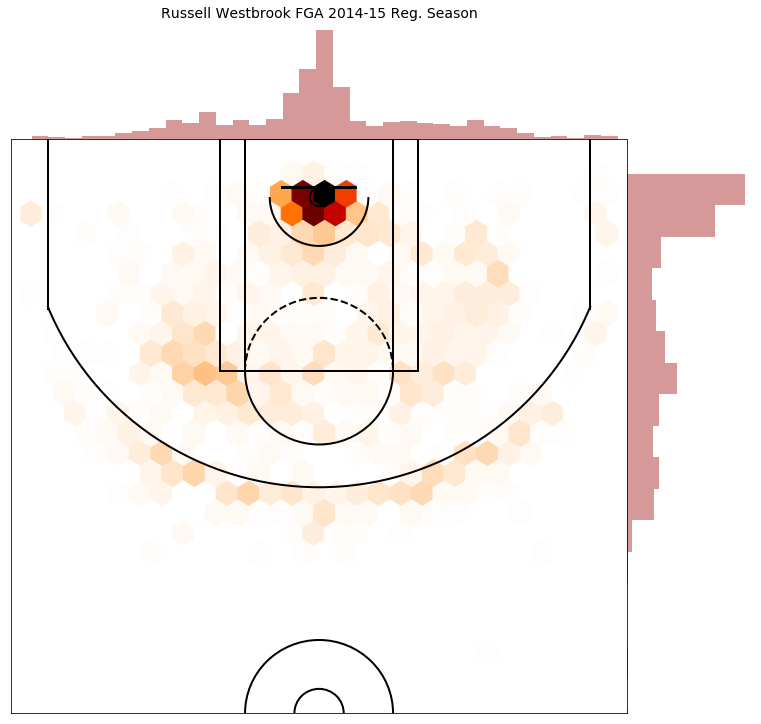

In [59]:
rw = df[df.name=='Russell Westbrook']
# create our jointplot

cmap=plt.cm.gist_heat_r
joint_shot_chart = sns.jointplot(rw.x, rw.y, stat_func=None,
                                 kind='hex', space=0, color=cmap(.6), cmap=cmap)

joint_shot_chart.fig.set_size_inches(12,11)

# A joint plot has 3 Axes, the first one called ax_joint 
# is the one we want to draw our court onto 
ax = joint_shot_chart.ax_joint
draw_court(ax)

# Adjust the axis limits and orientation of the plot in order
# to plot half court, with the hoop by the top of the plot
ax.set_xlim(-250,250)
ax.set_ylim(422.5, -47.5)

# Get rid of axis labels and tick marks
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelbottom='off', labelleft='off')

# Add a title
ax.set_title(rw.name.unique()[0] + ' FGA 2014-15 Reg. Season', y=1.2, fontsize=14)

plt.show()

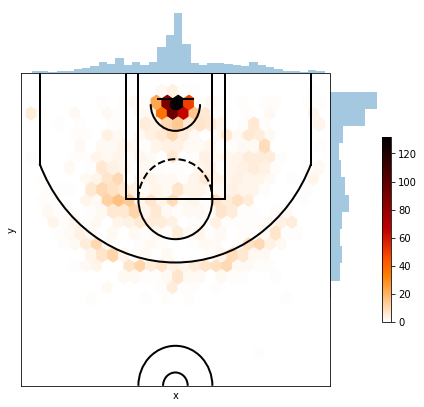

In [60]:
cmap=plt.cm.gist_heat_r
joint_shot_chart = sns.jointplot(rw.x, rw.y, stat_func=None,
                                 kind='hex', space=0, cmap=cmap)

# joint_shot_chart.fig.set_size_inches(12,11)
ax = joint_shot_chart.ax_joint
draw_court(ax)
ax.set_xlim(-250,250)
ax.set_ylim(422.5, -47.5)
plt.colorbar();

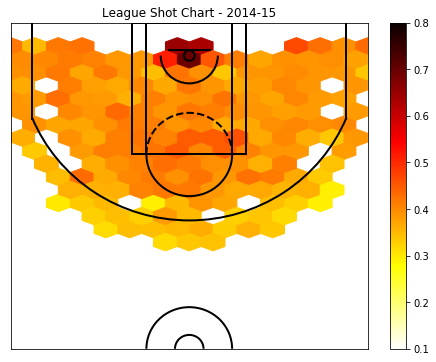

In [61]:
plt.figure(figsize=(8,6))
plt.hexbin(df.x,df.y,gridsize=(15,24),C=df.shot_made_flag,
           bins=None, cmap=plt.cm.hot_r, mincnt=200,
           vmin=0.1,vmax=.8)
ax=draw_court()
ax.set_xlim(-250,250)
ax.set_ylim(422.5, -47.5)
plt.title('League Shot Chart - 2014-15')
#ax.text(-250,445,'Note: Colors Represent FG% Relative to League Average')
plt.colorbar();

In [62]:
sc = df[df.name=='Stephen Curry']

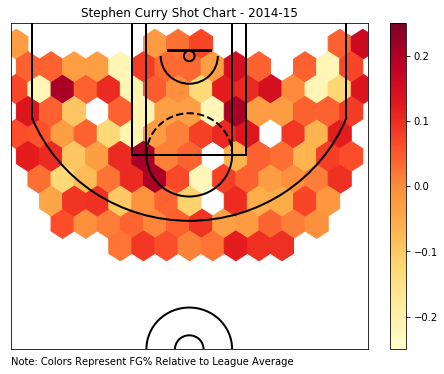

In [64]:
plt.figure(figsize=(8,6))
plt.hexbin(sc.x,sc.y,gridsize=(15,12),C=sc.shot_made_flag-sc.lg_avg,
           bins='log', cmap=plt.cm.YlOrRd, mincnt=1,
           vmin=-.25,vmax=.25)
ax2=draw_court()
ax2.set_xlim(-250,250)
ax2.set_ylim(422.5, -47.5)
plt.title(sc.name.unique()[0] + ' Shot Chart - 2014-15')
ax2.text(-250,445,'Note: Colors Represent FG% Relative to League Average')
plt.colorbar();

In [ ]:
plt.hexbin(sc.x[sc.shot_area=='C'],sc.y[sc.shot_area=='C'], gridsize=(15,24),
           C=sc.shot_made_flag[sc.shot_area=='C']-sc.lg_avg[sc.shot_area=='C'], bins='log',
           cmap=plt.cm.YlOrRd, mincnt=1, vmin=-.75,vmax=.75)
ax3=draw_court()
ax3.set_xlim(-250,250)
ax3.set_ylim(422.5,-47.5);

In [83]:
gsw = df[df.team_name=='Golden State Warriors'].reset_index(drop=True)

In [84]:
gsw_tab = pd.crosstab(gsw.name, columns=[gsw.shot_made_flag, gsw.shot_zone, gsw.shot_area],
                      margins=True, margins_name='FGA')

In [85]:
fgm_arr = []
for player in gsw_tab.index:
    fgm_arr.append(len(gsw[(gsw.name==player)&(gsw.shot_made_flag==1)]))

In [86]:
gsw_tab['FGM'] = fgm_arr
gsw_tab['FG_PCT'] = round(gsw_tab.FGM/gsw_tab.FGA,3)
gsw_tab

shot_made_flag                   0                                       \
shot_zone            Above Break 3           Corner 3      Heave          
shot_area                        C    L    R        L    R     C   L  R   
name                                                                      
Andre Iguodala                  17   26   33       27   29     4   0  2   
Andrew Bogut                     0    0    0        0    0     0   0  0   
Brandon Rush                     4    9    5        5    1     0   0  0   
David Lee                        1    0    0        0    0     0   0  1   
Draymond Green                  74   80   43       17    4     0   0  0   
Festus Ezeli                     0    0    0        0    0     0   0  0   
Harrison Barnes                  9   33   24       39   22     0   1  0   
James Michael McAdoo             0    0    0        0    0     0   0  0   
Justin Holiday                   4   25   28        7    9     1   0  0   
Klay Thompson                   45   79  111       29   35     0   2  2   
Leandro Barbosa                 11   22   17        8    9     0   2  0   
Marreese Speights                2    1    3        2    1     1   0  3   
Ognjen Kuzmic                    0    0    0        0    0     0   0  0   
Shaun Livingston                 0    0    1        0    0     1   0  0   
Stephen Curry                   95   98  122       14   21     2   6  1   
FGA                            262  373  387      148  131     9  11  9   

shot_made_flag                                                            \
shot_zone            Mid Range           Paint           Restricted Area   
shot_area                    C    L    R     C    L    R               C   
name                                                                       
Andre Iguodala              10   27   18    18    7    9              38   
Andrew Bogut                 2    4    9    42    8   14              76   
Brandon Rush                 1    6    2     2    0    1               7   
David Lee                    7   14   15    35   12    7              61   
Draymond Green              11   18   23    34   11   13              98   
Festus Ezeli                 1    6    4    11    6    6              29   
Harrison Barnes             13   30   45    23   13   15              73   
James Michael McAdoo         0    1    1     1    1    2              14   
Justin Holiday               9    8   15     9    3    2              24   
Klay Thompson               43   63   92    63   17   26              90   
Leandro Barbosa              8   20   16    23    5    5              57   
Marreese Speights           61   48   72    27    3   19              85   
Ognjen Kuzmic                0    1    0     1    0    0               2   
Shaun Livingston             5   43   28    34   26   21              39   
Stephen Curry               31   70   66    41    7   18              95   
FGA                        202  359  406   364  119  158             788   

shot_made_flag                   1                                          \
shot_zone            Above Break 3           Corner 3      Heave Mid Range   
shot_area                        C    L    R        L    R     R         C   
name                                                                         
Andre Iguodala                   9   20   19       15   11     0         7   
Andrew Bogut                     0    0    0        0    0     0         0   
Brandon Rush                     0    1    1        1    0     0         0   
David Lee                        0    0    0        0    0     0         4   
Draymond Green                  47   38   18        3    5     0         6   
Festus Ezeli                     0    0    0        0    0     0         0   
Harrison Barnes                  4   16   13       23   31     0        12   
James Michael McAdoo             0    0    0        0    0     0         0   
Justin Holiday                   5   10   

In [90]:
# #gsw_arr = np.zeros((15,len(gsw_tab.columns[:-3])/2))
# for index, col in enumerate(gsw_tab.columns[:-3]):
#     if col[1]!='Heave':
#         print(round(gsw_tab[0][col[1]][col[2]]/gsw_tab[1][col[1]][col[2]],3))

In [89]:
gsw_tab

shot_made_flag                   0                                       \
shot_zone            Above Break 3           Corner 3      Heave          
shot_area                        C    L    R        L    R     C   L  R   
name                                                                      
Andre Iguodala                  17   26   33       27   29     4   0  2   
Andrew Bogut                     0    0    0        0    0     0   0  0   
Brandon Rush                     4    9    5        5    1     0   0  0   
David Lee                        1    0    0        0    0     0   0  1   
Draymond Green                  74   80   43       17    4     0   0  0   
Festus Ezeli                     0    0    0        0    0     0   0  0   
Harrison Barnes                  9   33   24       39   22     0   1  0   
James Michael McAdoo             0    0    0        0    0     0   0  0   
Justin Holiday                   4   25   28        7    9     1   0  0   
Klay Thompson                   45   79  111       29   35     0   2  2   
Leandro Barbosa                 11   22   17        8    9     0   2  0   
Marreese Speights                2    1    3        2    1     1   0  3   
Ognjen Kuzmic                    0    0    0        0    0     0   0  0   
Shaun Livingston                 0    0    1        0    0     1   0  0   
Stephen Curry                   95   98  122       14   21     2   6  1   
FGA                            262  373  387      148  131     9  11  9   

shot_made_flag                                                            \
shot_zone            Mid Range           Paint           Restricted Area   
shot_area                    C    L    R     C    L    R               C   
name                                                                       
Andre Iguodala              10   27   18    18    7    9              38   
Andrew Bogut                 2    4    9    42    8   14              76   
Brandon Rush                 1    6    2     2    0    1               7   
David Lee                    7   14   15    35   12    7              61   
Draymond Green              11   18   23    34   11   13              98   
Festus Ezeli                 1    6    4    11    6    6              29   
Harrison Barnes             13   30   45    23   13   15              73   
James Michael McAdoo         0    1    1     1    1    2              14   
Justin Holiday               9    8   15     9    3    2              24   
Klay Thompson               43   63   92    63   17   26              90   
Leandro Barbosa              8   20   16    23    5    5              57   
Marreese Speights           61   48   72    27    3   19              85   
Ognjen Kuzmic                0    1    0     1    0    0               2   
Shaun Livingston             5   43   28    34   26   21              39   
Stephen Curry               31   70   66    41    7   18              95   
FGA                        202  359  406   364  119  158             788   

shot_made_flag                   1                                          \
shot_zone            Above Break 3           Corner 3      Heave Mid Range   
shot_area                        C    L    R        L    R     R         C   
name                                                                         
Andre Iguodala                   9   20   19       15   11     0         7   
Andrew Bogut                     0    0    0        0    0     0         0   
Brandon Rush                     0    1    1        1    0     0         0   
David Lee                        0    0    0        0    0     0         4   
Draymond Green                  47   38   18        3    5     0         6   
Festus Ezeli                     0    0    0        0    0     0         0   
Harrison Barnes                  4   16   13       23   31     0        12   
James Michael McAdoo             0    0    0        0    0     0         0   
Justin Holiday                   5   10   